<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/dl-time-series-forecasting/blob/main/Multivariat_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Soedirman-Machine-Learning/dl-time-series-forecasting

fatal: destination path 'dl-time-series-forecasting' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from pandas import read_csv

df = pd.read_csv('https://raw.githubusercontent.com/Soedirman-Machine-Learning/dl-time-series-forecasting/main/dataset_VAR_Multivariat.csv', parse_dates=['date'], index_col='date')

print(df.shape)
df.tail()


(2394, 8)


,u1,u2,u3,u4,u5,u6,u7,y
date,,,,,,,,
2006-07-17,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2006-07-18,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2006-07-19,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2006-07-20,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023
2006-07-21,0.215821,0.668945,0.677877,0.351774,0.500161,0.684994,0.569601,0.149922


In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,u1_x,u2_x,u3_x,u4_x,u5_x,u6_x,u7_x,y_x
u1_y,1.0,0.0001,0.0,0.0001,0.0000,0.0000,0.0000,0.0000
u2_y,0.0,1.0000,0.0,0.4507,0.0002,0.0213,0.0117,0.0012
u3_y,0.0,0.0000,1.0,0.0000,0.0000,0.0000,0.0000,0.0631
u4_y,0.0,0.0000,0.0,1.0000,0.0049,0.0002,0.0015,0.2333
u5_y,0.0,0.0000,0.0,0.0002,1.0000,0.0000,0.0000,0.0000
u6_y,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0006
u7_y,0.0,0.0000,0.0,0.0000,0.0000,0.0000,1.0000,0.0000
y_y,0.0,0.0000,0.0,0.0406,0.0000,0.0000,0.0000,1.0000


In [5]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
u1     ::  542.53    > 143.6691  =>   True
u2     ::  312.81    > 111.7797  =>   True
u3     ::  210.11    > 83.9383   =>   True
u4     ::  150.74    > 60.0627   =>   True
u5     ::  92.79     > 40.1749   =>   True
u6     ::  43.42     > 24.2761   =>   True
u7     ::  6.14      > 12.3212   =>   False
y      ::  0.2       > 4.1296    =>   False


In [8]:
nobs = 239
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (2155, 8)
print(df_test.shape)  # (239, 8)

(2155, 8)
(239, 8)


In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "u1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3599
 No. Lags Chosen       = 13
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9561
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [12]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "u1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.303
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4862
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [13]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [14]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "u1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.396
 No. Lags Chosen       = 19
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.2565
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [15]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -61.08663012081168
BIC :  -60.89678857325951
FPE :  2.9540224387979424e-27
HQIC:  -61.01718237903193 

Lag Order = 2
AIC :  -61.93413590574845
BIC :  -61.575408994739426
FPE :  1.265749248347657e-27
HQIC:  -61.80290351174847 

Lag Order = 3
AIC :  -62.40151744531157
BIC :  -61.87377575962583
FPE :  7.931748825698619e-28
HQIC:  -62.208450142705765 

Lag Order = 4
AIC :  -62.783842338125424
BIC :  -62.08695630522006
FPE :  5.411679999590204e-28
HQIC:  -62.52888980606686 

Lag Order = 5
AIC :  -63.056725053101786
BIC :  -62.190564938834456
FPE :  4.119346968640584e-28
HQIC:  -62.739836906169685 

Lag Order = 6
AIC :  -63.25039376259509
BIC :  -62.21482967094698
FPE :  3.3941462658086865e-28
HQIC:  -62.871519550682194 

Lag Order = 7
AIC :  -63.45966971723039
BIC :  -62.25457159002865
FPE :  2.753334899610288e-28
HQIC:  -63.01875892542998 

Lag Order = 8
AIC :  -63.592702690584105
BIC :  -62.21794030722359
FPE :  2.4104860385898617e-28
HQIC:  -63.089704739076794 

Lag 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [16]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-59.13,-59.11,2.094e-26,-59.12
1,-61.06,-60.87,3.030e-27,-60.99
2,-61.91,-61.55,1.296e-27,-61.78
3,-62.38,-61.85,8.094e-28,-62.19
4,-62.76,-62.07,5.516e-28,-62.51
5,-63.04,-62.17,4.185e-28,-62.72
6,-63.23,-62.20,3.447e-28,-62.86
7,-63.45,-62.24*,2.787e-28,-63.01
8,-63.58,-62.21,2.434e-28,-63.08
9,-63.67,-62.13,2.221e-28,-63.11


In [17]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, Oct, 2021
Time:                     08:27:02
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -61.5754
Nobs:                     2151.00    HQIC:                  -61.8029
Log likelihood:           42329.1    FPE:                1.26575e-27
AIC:                     -61.9341    Det(Omega_mle):     1.18849e-27
--------------------------------------------------------------------
Results for equation u1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000001         0.000366            0.003           0.997
L1.u1        -0.316716         0.021983          -14.407           0.000
L1.u2         0.031970         0.009972            3.206           0.001
L1.u3        -0.041370

In [18]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

u1 : 2.06
u2 : 2.23
u3 : 2.1
u4 : 2.05
u5 : 2.1
u6 : 2.2
u7 : 2.2
y : 2.06


In [19]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

2


array([[-6.50000000e-07, -8.03200600e-02, -4.65631000e-03,
         2.70000000e-07, -1.76738800e-02, -3.24398000e-03,
         1.52271000e-02,  1.05120000e-04],
       [ 9.99999999e-09,  8.24870100e-02,  3.20831000e-03,
        -2.80000000e-07, -1.04061500e-02,  8.59428000e-03,
        -1.92573300e-02,  3.48529000e-03]])

In [20]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,u1_2d,u2_2d,u3_2d,u4_2d,u5_2d,u6_2d,u7_2d,y_2d
date,,,,,,,,
2005-11-25,-0.000422,-0.030713,-0.016021,-0.004230,0.000200,-0.013995,0.001462,-5.050132e-04
2005-11-26,0.000703,-0.012346,0.007941,0.006130,0.010036,0.014770,0.012159,4.631835e-04
2005-11-27,0.000149,0.021874,0.001470,-0.002686,-0.005139,-0.001695,-0.005200,-1.258654e-04
2005-11-28,0.000156,-0.010266,-0.000200,-0.000659,-0.000306,-0.007789,-0.002574,1.571970e-04
2005-11-29,-0.000478,-0.001862,-0.001892,0.001526,0.001136,0.006045,0.001821,-6.621840e-05
...,...,...,...,...,...,...,...,...
2006-07-17,0.000001,-0.000006,0.000005,0.000002,0.000004,0.000008,0.000007,5.319994e-07
2006-07-18,0.000001,-0.000006,0.000005,0.000002,0.000004,0.000008,0.000007,5.319994e-07
2006-07-19,0.000001,-0.000006,0.000005,0.000002,0.000004,0.000008,0.000007,5.319994e-07


In [21]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [22]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['y_forecast']]

,y_forecast
date,
2005-11-25,0.350167
2005-11-26,0.349139
2005-11-27,0.347985
2005-11-28,0.346989
2005-11-29,0.345927
...,...
2006-07-17,0.123126
2006-07-18,0.122219
2006-07-19,0.121312


In [23]:
df.tail(239)

,u1,u2,u3,u4,u5,u6,u7,y
date,,,,,,,,
2005-11-25,0.337473,0.671934,0.524101,0.368318,0.586803,0.490805,0.456981,0.346001
2005-11-26,0.340768,0.666930,0.521820,0.367909,0.577132,0.484467,0.480017,0.347278
2005-11-27,0.344063,0.685803,0.530404,0.367501,0.597173,0.477137,0.466510,0.340473
2005-11-28,0.347357,0.664150,0.532751,0.367092,0.598607,0.504114,0.482497,0.335854
2005-11-29,0.350652,0.670530,0.531067,0.366684,0.600039,0.552976,0.502588,0.333758
...,...,...,...,...,...,...,...,...
2006-07-17,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2006-07-18,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2006-07-19,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742


In [30]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae, 
             'rmse':rmse})

print('Forecast Accuracy of: y')
accuracy_prod = forecast_accuracy(df_results['y_forecast'].values, df_test['y'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))


Forecast Accuracy of: y
mape :  inf
mae :  0.1284
rmse :  0.148


In [37]:
y_pred = df_results['y_forecast']
y__actual = df_test['y']

Text(0.5, 1.0, 'y')

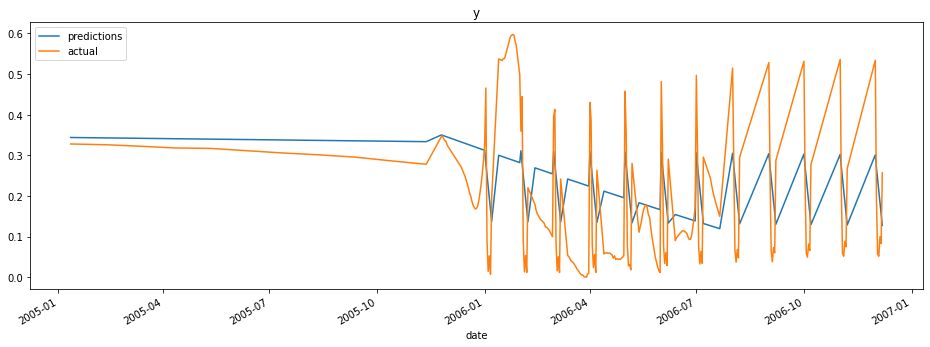

In [41]:
from matplotlib.pyplot import figure
plt.figure(1)
plt.subplot(211)
y_pred.plot(figsize = (16,12), label ="predictions")
y__actual.plot(figsize = (16,12), label = "actual")
plt.legend(fontsize=10)
plt.title('y')